## FTP Connection

### Connection Parameters

In [158]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [159]:
# The topic of interest daily precipitation historical data 
topic_dir = "daily/more_precip/historical/" 

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [160]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [161]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD/daily/more_precip/historical/
data/original/DWD/daily/more_precip/historical/

data/generated/DWD/
data/generated/DWD/daily/more_precip/historical/
data/generated/DWD/daily/more_precip/historical/
data/generated/DWD/daily/more_precip/historical/


In [162]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [163]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [164]:
ret = ftp.cwd(".")
os.getcwd()

'C:\\Users\\Rajesh Rao\\OneDrive\\Documents\\Masters\\Winter\\GIS\\Final Assignment\\Python'

In [165]:
#ftp.quit()

### FTP Grab File Function

In [166]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [167]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [168]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [169]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_more_pre...,.pdf,72261,-
1,-1,DESCRIPTION_obsgermany_climate_daily_more_prec...,.pdf,71026,-
2,-1,RR_Tageswerte_Beschreibung_Stationen.txt,.txt,1202111,-
3,1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
4,2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
5,3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
6,4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
7,6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-
8,7,tageswerte_RR_00007_19510101_19960131_hist.zip,.zip,69540,-
9,8,tageswerte_RR_00008_19310101_19911231_hist.zip,.zip,88001,-


### Dataframe with TS Zip Files

In [170]:
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-
7,tageswerte_RR_00007_19510101_19960131_hist.zip,.zip,69540,-
8,tageswerte_RR_00008_19310101_19911231_hist.zip,.zip,88001,-
9,tageswerte_RR_00009_19920601_20101231_hist.zip,.zip,31560,-
10,tageswerte_RR_00010_19610101_20050831_hist.zip,.zip,66983,-


### Download the Station Description File

In [171]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Tageswerte_Beschreibung_Stationen.txt


In [172]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate/daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD/daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [173]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [174]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1912-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
2,1951-01-01,2006-12-31,138,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
4,1951-01-01,1979-10-31,243,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen
6,1982-11-01,2020-03-01,455,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg


### Select Stations Located in NRW from Station Description Dataframe

In [175]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    2,     3,     4,    38,    42,    79,    98,   104,   110,
              186,
            ...
            15456, 15559, 15919, 15927, 15963, 15980, 16087, 19042, 19043,
            19125],
           dtype='int64', name='station_id', length=500)

### Exract Only NRW stations around Xanten area

In [176]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"  

# Create variable with TRUE if station name is Xanten
xanten= df_stations['name'] == "Xanten"

dfXanten = df_stations[xanten]

# all the latitudes with in range XantenLatitude ± 0.2
isLatCovered = (df_stations['latitude'] < dfXanten.iloc[0]['latitude'] + 0.2)&(df_stations['latitude'] > dfXanten.iloc[0]['latitude'] - 0.2)

# all the latitudes with in range XantenLongitude ± 0.2 (± 0.2 because there were no dataset within the required date range)
isLongCovered = (df_stations['longitude'] < dfXanten.iloc[0]['longitude'] + 0.2)&(df_stations['longitude'] > dfXanten.iloc[0]['longitude'] - 0.2)

# Considering starting date range from anytime before 2015
dateFilter=(df_stations['date_from'] <= '2015')

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to']>= '2018' 

# select on all conditions above
dfNRW = df_stations[isNRW & isLatCovered & isLongCovered & dateFilter & isOperational]

dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
554,1946-01-01,2020-03-01,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
1999,1931-01-01,2020-03-01,23,51.7217,6.5839,Hamminkeln-Mühlenrott,Nordrhein-Westfalen
5502,1951-01-01,2020-03-01,25,51.6927,6.5853,Wesel-Flüren,Nordrhein-Westfalen
5733,1951-01-01,2020-03-01,20,51.6970,6.3974,Xanten,Nordrhein-Westfalen
14175,2012-06-07,2020-03-01,22,51.5786,6.5095,Alpen (WV NRW),Nordrhein-Westfalen
14177,2014-08-01,2020-03-01,24,51.5426,6.3150,Geldern (Klärwerk) (WV NRW),Nordrhein-Westfalen


In [177]:
#Export all the selected station data into csv
export_csv = dfNRW.to_csv (r'Precipitaion_Stations_Selected.csv', index = None, header=True)

In [178]:
print(df_zips)

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  109677    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   82951    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  162410    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   45468    -
6           tageswerte_RR_00006_19821101_20181231_hist.zip  .zip   38084    -
...                                                    ...   ...     ...  ...
19042       tageswerte_RR_19042_18980601_19401231_hist.zip  .zip   63442    -
19043       tageswerte_RR_19043_19410101_19700731_hist.zip  .zip   44469    -
19044       tageswerte_RR_19044_19060901_20050331_hist.zip  .zip   87399    -
19086       tageswerte_RR_19086_18991001_19891231_hist.zip  .zip  131370    -
19087       tageswerte_RR_19087_19570501_19951130_hist.zip  .zip

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [179]:
list(dfNRW.index)

[554, 1999, 5502, 5733, 14175, 14177]

In [180]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_RR_00554_19460101_20181231_hist.zip
tageswerte_RR_01999_19310101_20181231_hist.zip
tageswerte_RR_05502_19510101_20181231_hist.zip
tageswerte_RR_05733_19510101_20181231_hist.zip
tageswerte_RR_14175_20120607_20181231_hist.zip
tageswerte_RR_14177_20140801_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [181]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [182]:
from zipfile import ZipFile

In [183]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                
                if  dftmp.empty :
                    continue
                s = dftmp["rs"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [184]:
df_merged_ts = temp_ts_merge()


Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_00554_19460101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19460101_20181231_00554.txt

Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_01999_19310101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19310101_20181231_01999.txt

Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_05502_19510101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20181231_05502.txt

Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_05733_19510101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20181231_05733.txt

Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_14175_20120607_20181231_hist.zip
Extract product file: produkt_nieder_tag_20120607_20181231_14175.txt

Zip archive: data/original/DWD/daily/more_precip/historical/tageswerte_RR_14177_20140801_20181231_hist.zip
Extract 

In [185]:
df_merged_ts.head()

,554,1999,5502,5733
time,,,,
1931-01-01,NaN,7.9,NaN,NaN
1931-01-02,NaN,0.1,NaN,NaN
1931-01-03,NaN,14.0,NaN,NaN
1931-01-04,NaN,2.1,NaN,NaN
1931-01-05,NaN,2.9,NaN,NaN


### Selecting precipitation data from stations seleced for the time range
### (a) 2015-05-09 to 2016-05-08 (b) 2016-05-27 to 2017-05-26 (c) 2017-07-01 to 2018-06-30

In [186]:
df_selectedDateRange=pd.DataFrame()

try:
    df_merged_ts.reset_index(level = 0, inplace = True)
except:
    df_merged_ts.reset_index(drop = True)
 
    # Considered dates (a) 2016-05-08 (b) 2017-05-26 (c) 2018-05-11
date_from = [pd.Timestamp(2015, 5, 9), pd.Timestamp(2016, 5, 27), pd.Timestamp(2017, 7, 1)]
date_to = [pd.Timestamp(2016, 5, 8), pd.Timestamp(2017, 5, 26), pd.Timestamp(2018, 6, 30)]


i = 0
for item in date_from:
    isWithinDaterange = (df_merged_ts['time'] <= date_to[i]) & (df_merged_ts['time'] >= date_from[i])
    data_frame=df_merged_ts[isWithinDaterange] 
    
    # Calculating cumulative precipitation for each time period for each station
    data_frame = pd.concat([data_frame[[554, 1999,5502,5733]].cumsum(axis=0),data_frame['time']], axis=1)
    df_selectedDateRange = df_selectedDateRange.append(data_frame)
    i += 1

# extracting time and a precipitation data of a specific station [Xanten :5733]
selected_station = 'Xanten'  #Xanten station id = 5733
df_selectedDateRange = df_selectedDateRange.rename(columns={5733: selected_station})
export_csv = df_selectedDateRange[['time',selected_station]].to_csv (r'Precipitaion_Full_Data.csv', index = None, header=True)
df_selectedDateRange

,554,1999,5502,Xanten,time
30444,0.1,1.1,0.5,0.7,2015-05-09
30445,0.1,1.1,0.5,0.7,2015-05-10
30446,0.1,1.1,0.5,0.7,2015-05-11
30447,0.1,1.1,0.5,0.7,2015-05-12
30448,0.1,1.1,0.5,0.7,2015-05-13
...,...,...,...,...,...
31588,696.8,691.5,730.3,738.6,2018-06-26
31589,696.8,691.5,730.3,738.6,2018-06-27
31590,696.8,691.5,730.3,738.6,2018-06-28
31591,696.8,691.5,730.3,738.6,2018-06-29


### Plotting line graph for precipitation data selected

In [187]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

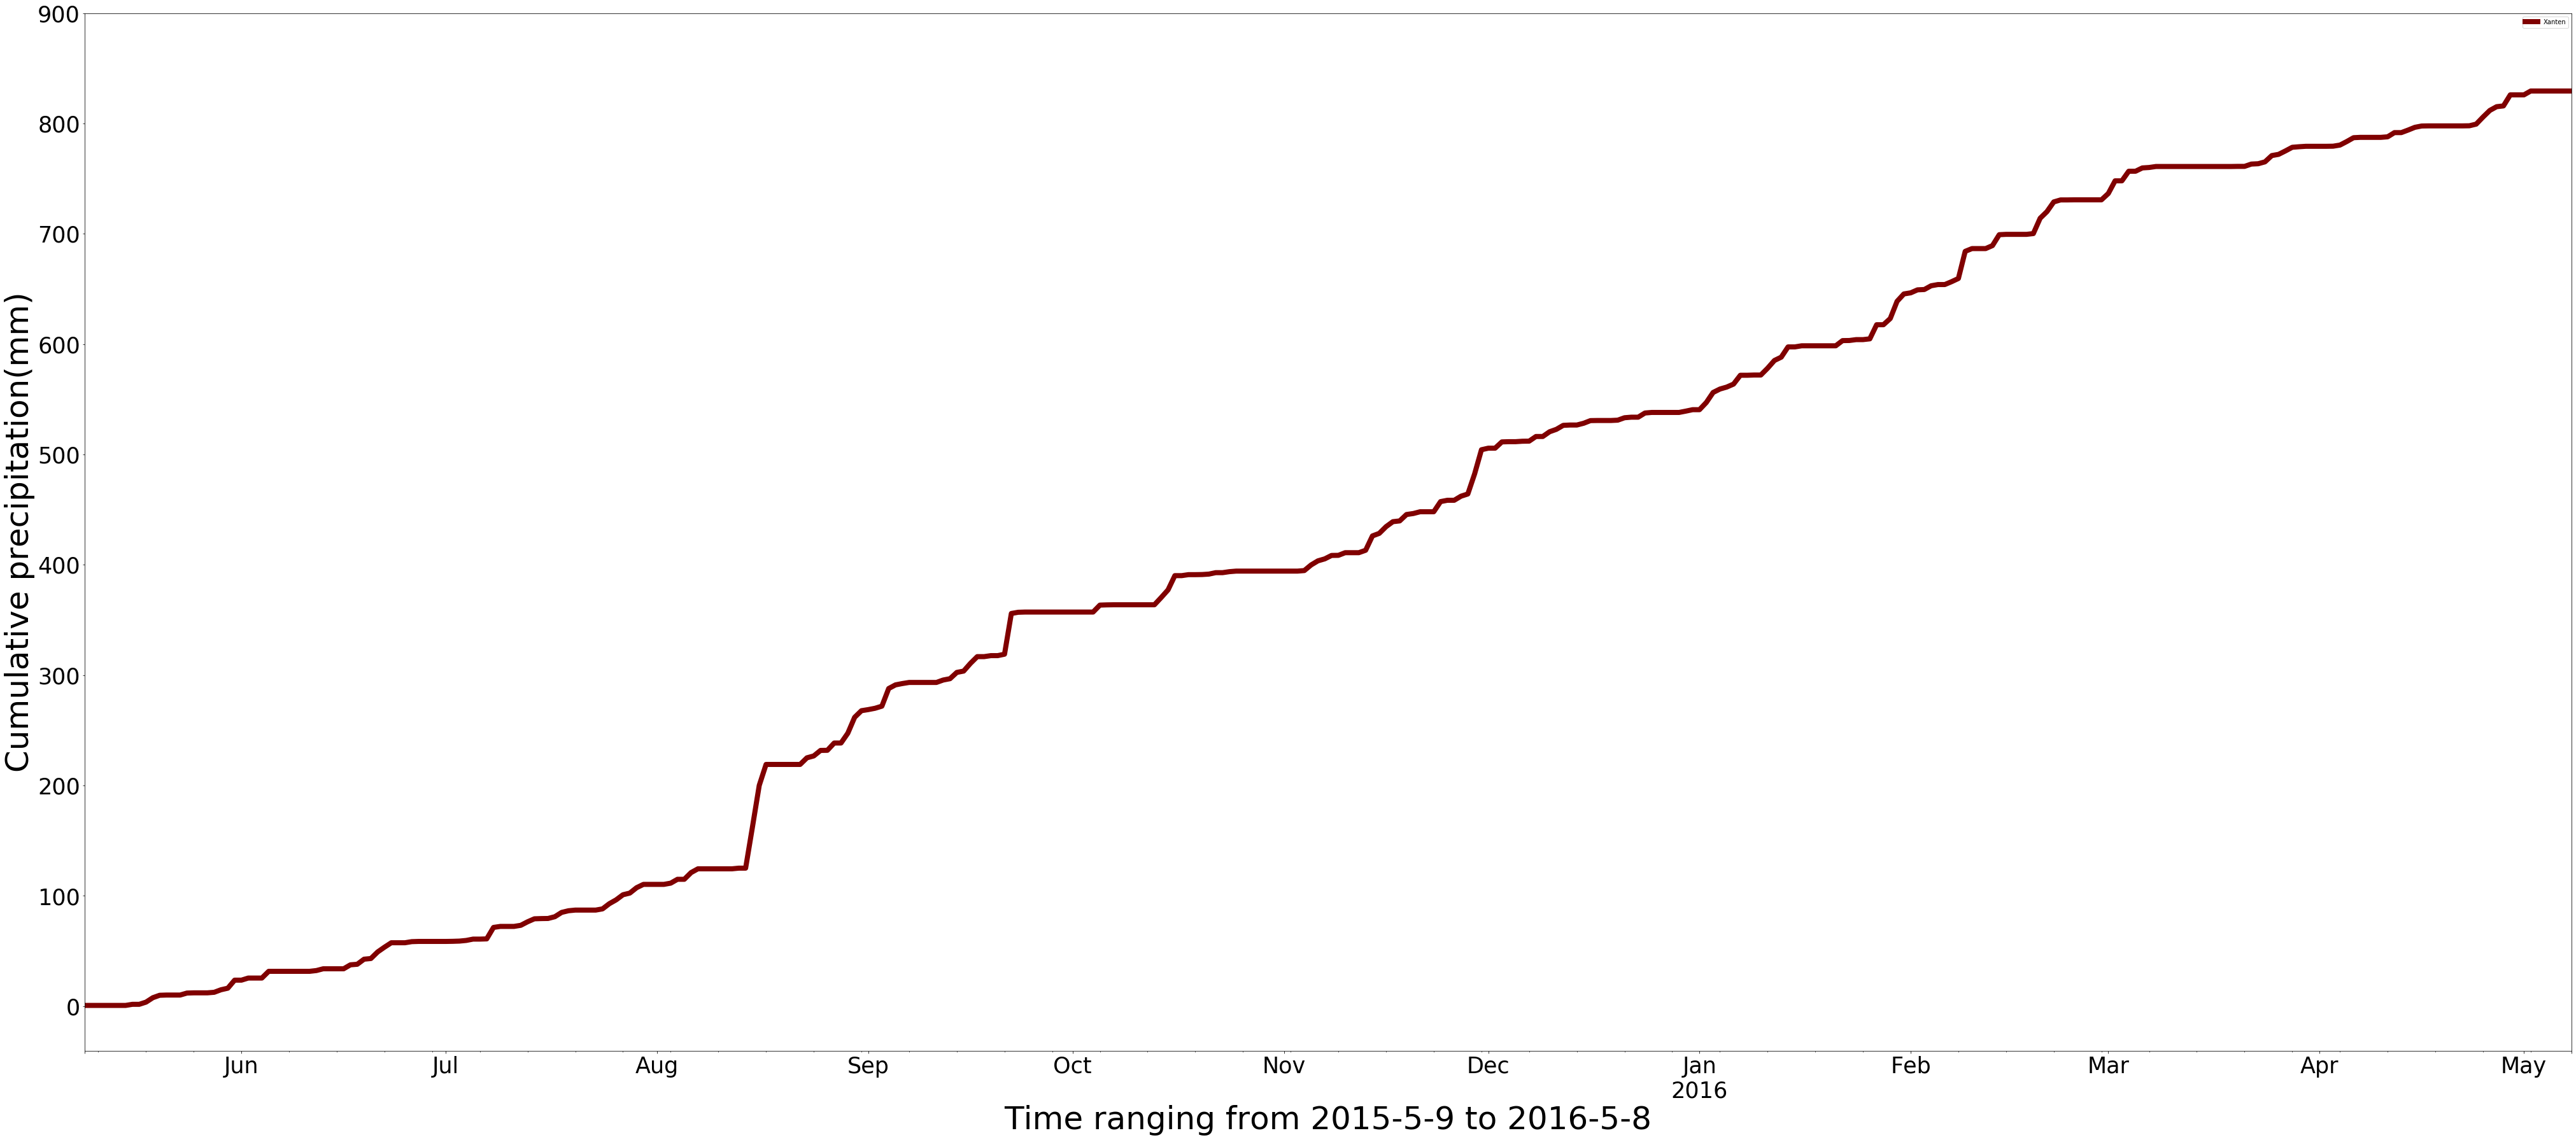

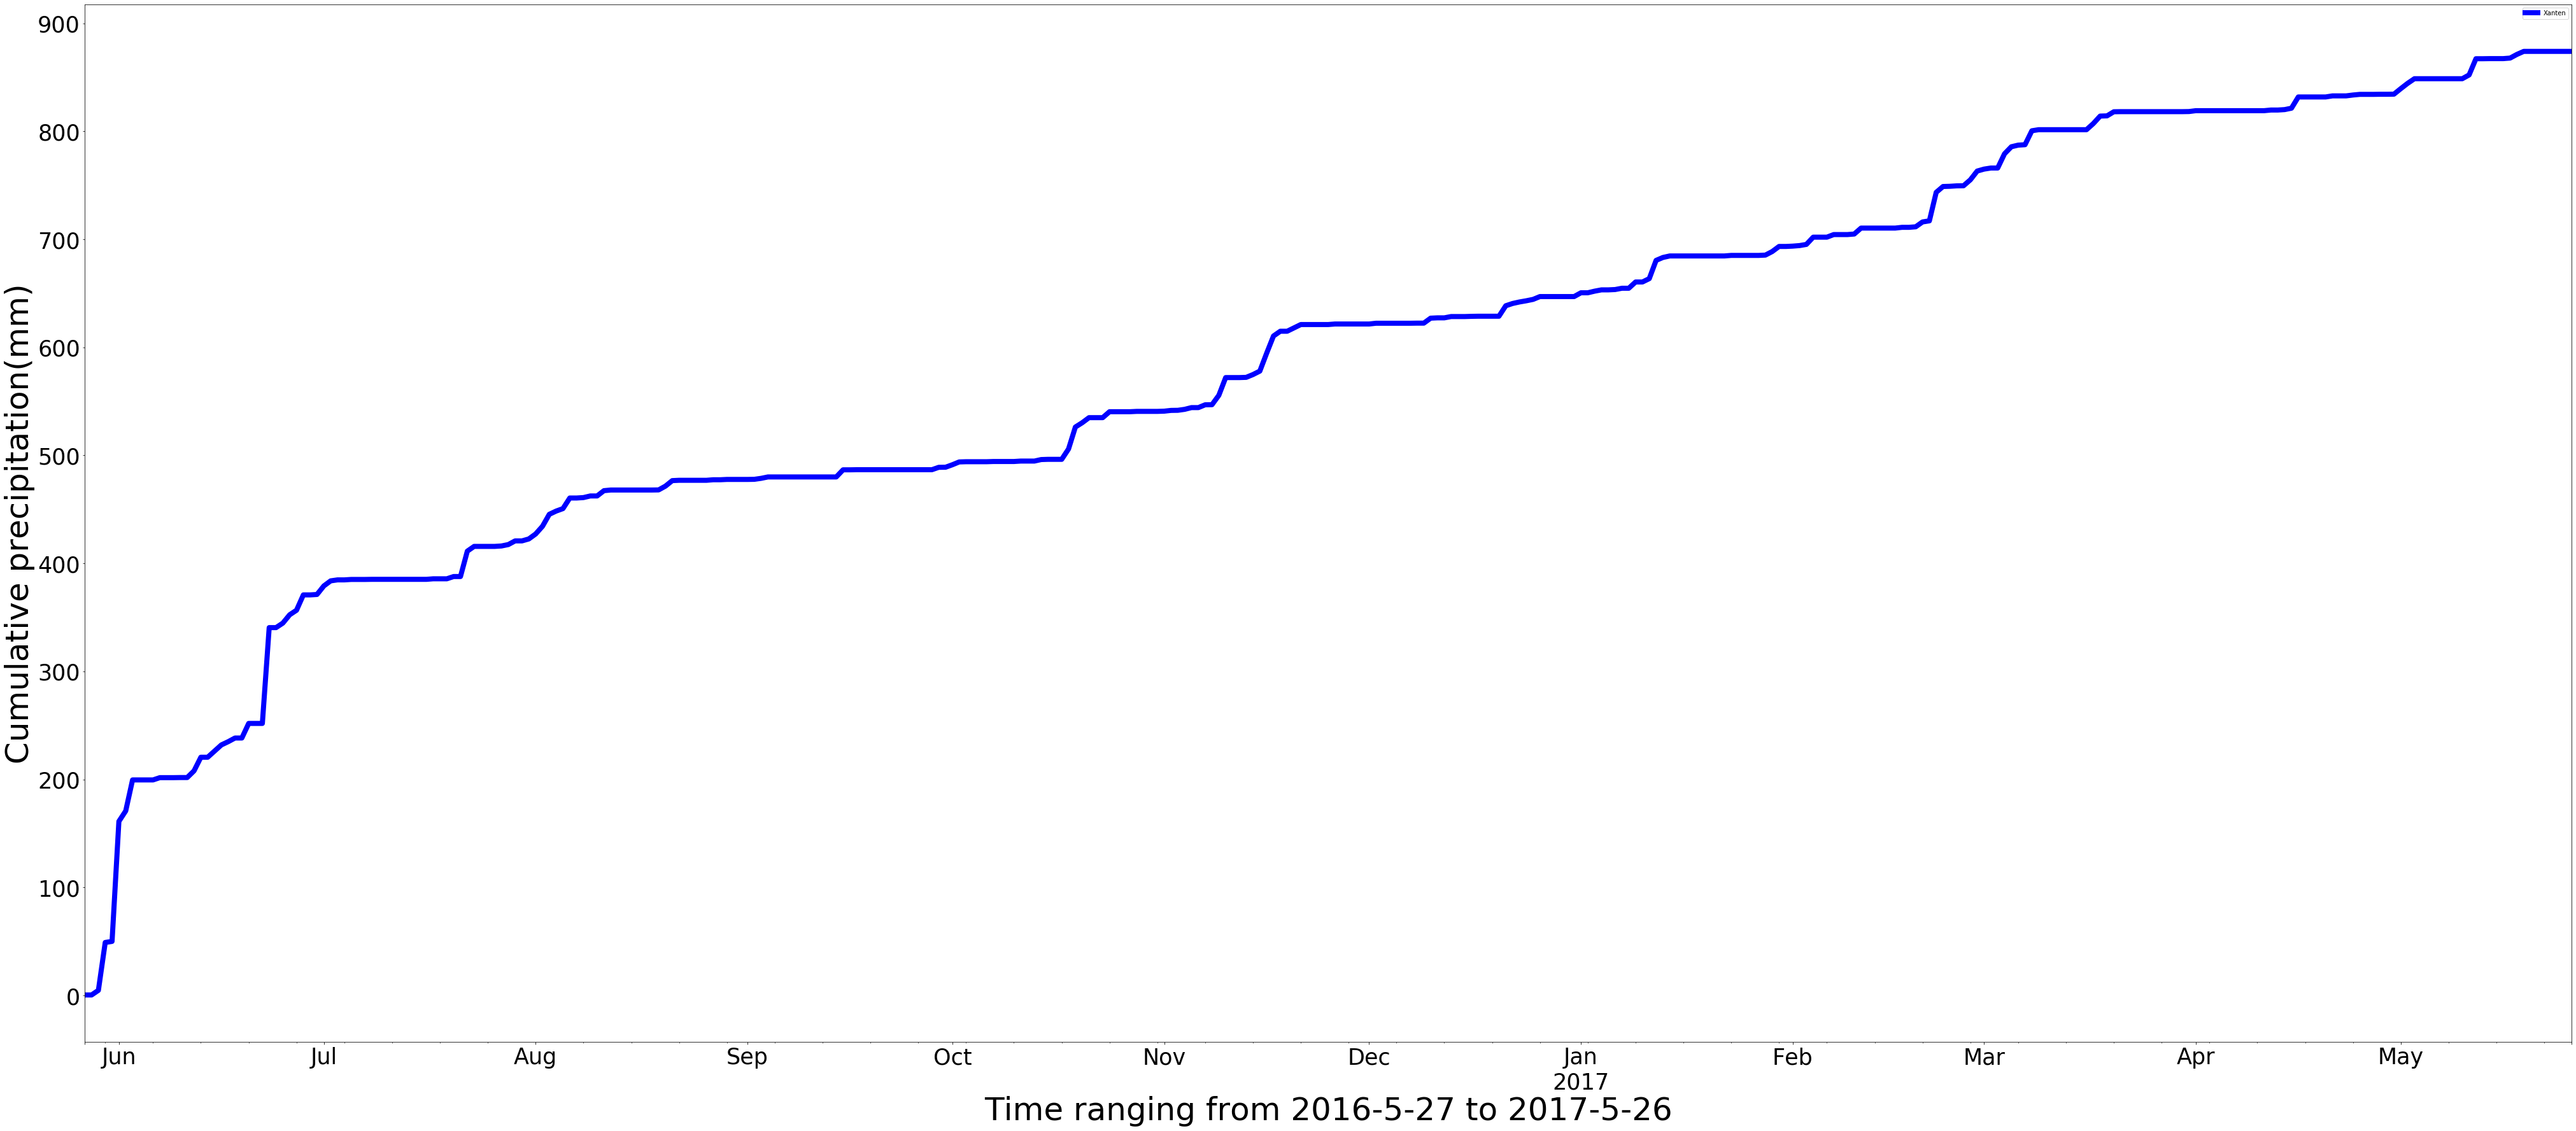

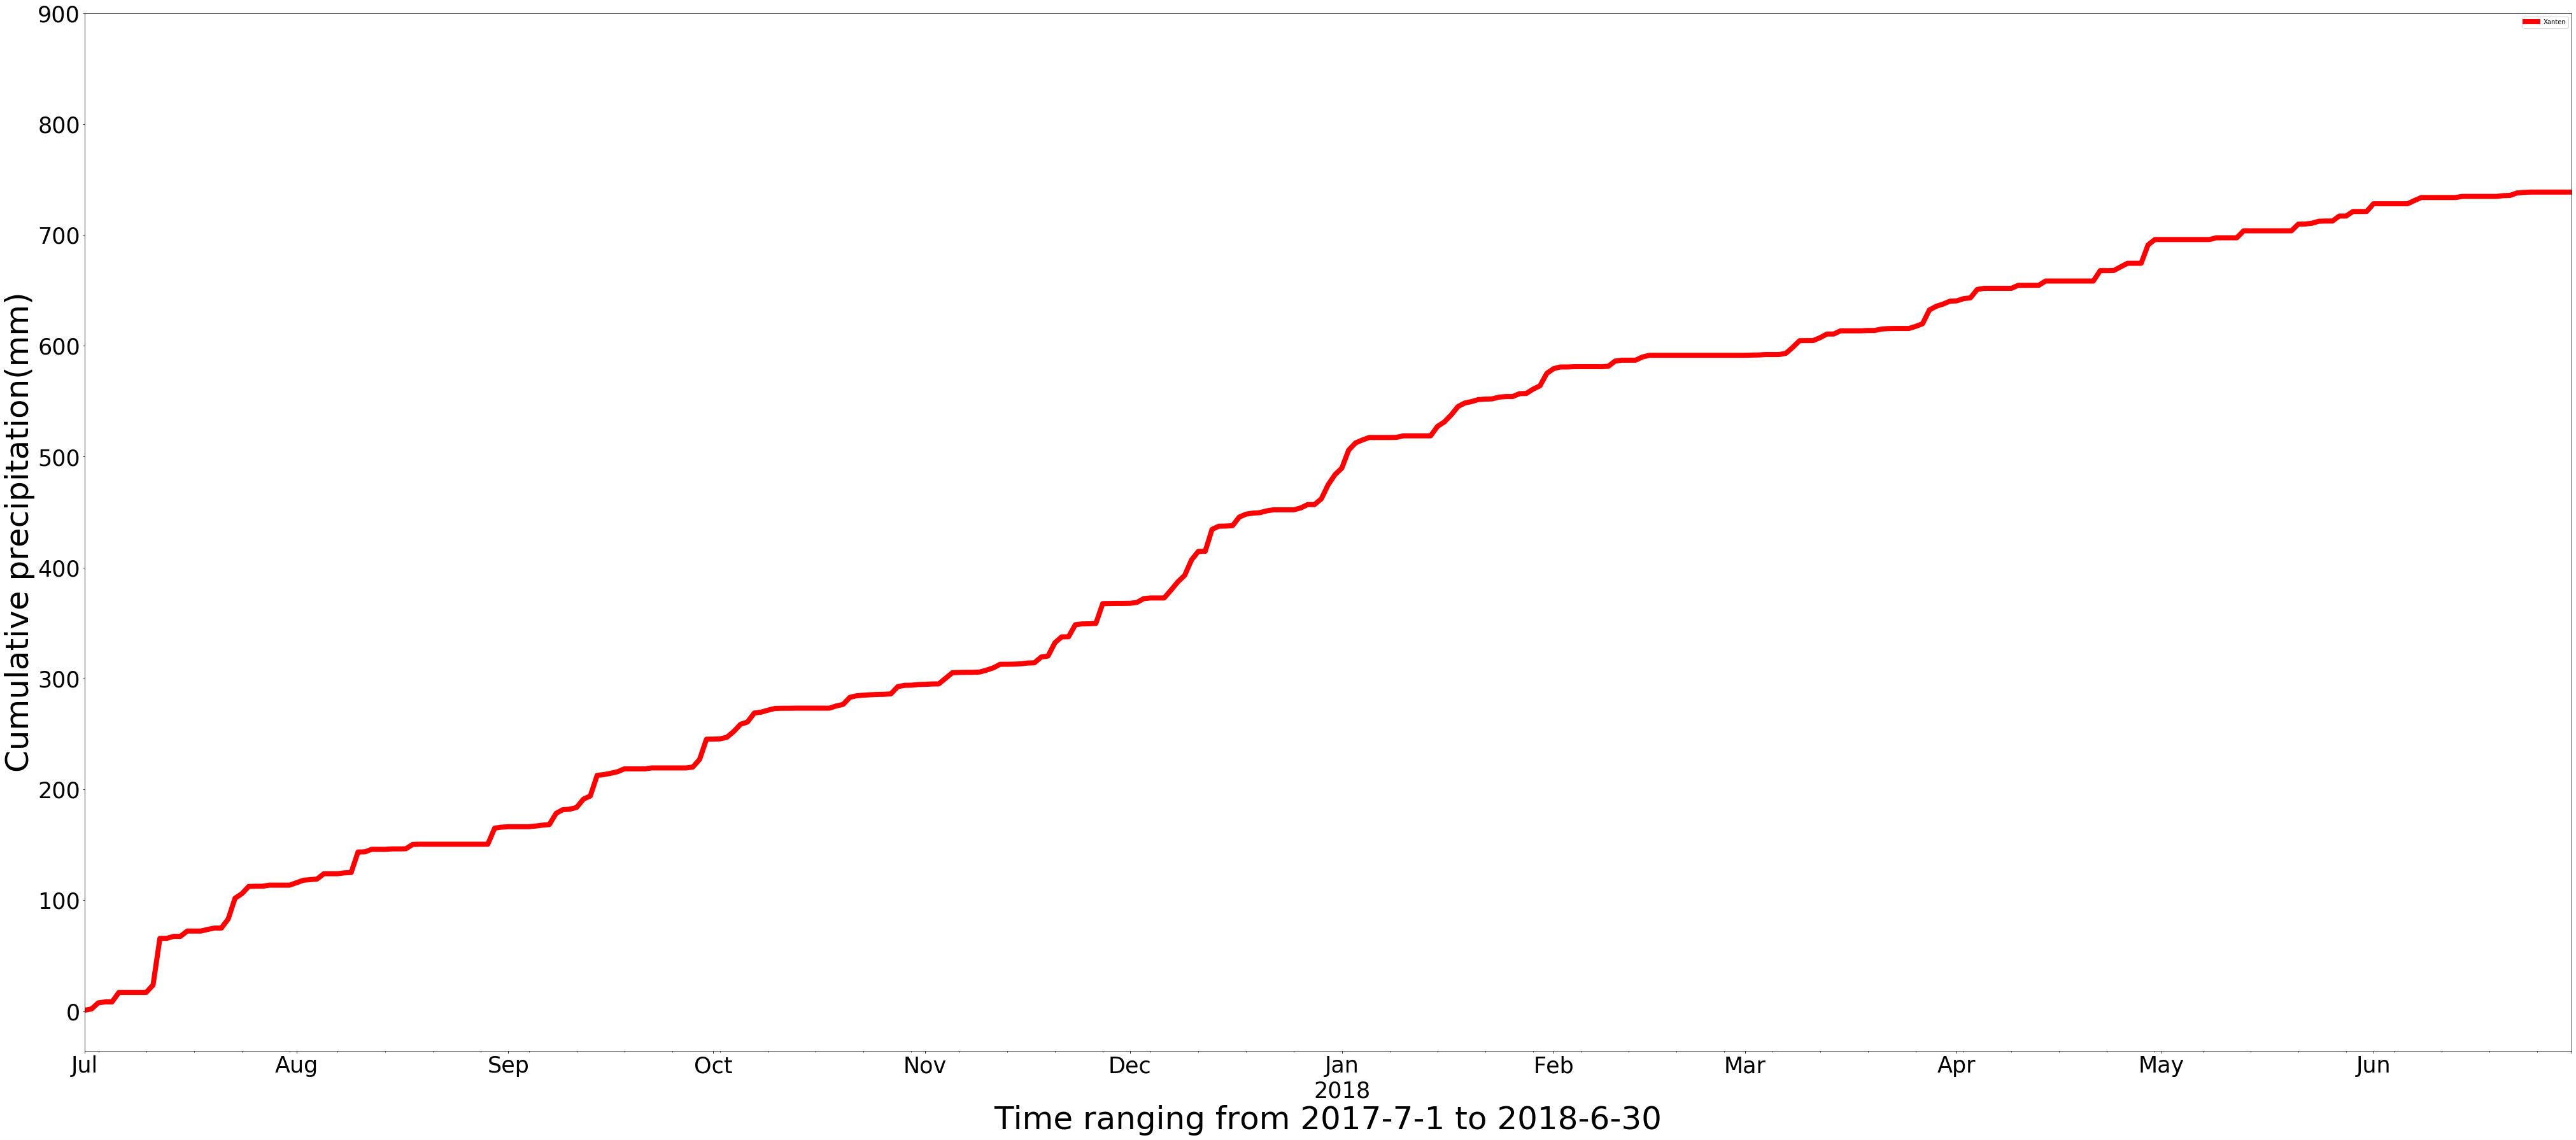

In [188]:
# Line plot for daily precipitation vs time from 2015-5-9 to 2016-5-8 for station 5733(XANTEN)
isWithinDaterange2016 = (df_selectedDateRange['time'] <= pd.Timestamp(2016, 5, 8)) & (df_selectedDateRange['time'] >= pd.Timestamp(2015, 5, 9))
df_selectedDateRange2016 = df_selectedDateRange[isWithinDaterange2016]
df_selectedDateRange2016.plot(kind='line',x='time',y=selected_station,color='maroon', linewidth = 8,figsize=(70, 30))

plt.xlabel('Time ranging from 2015-5-9 to 2016-5-8', fontsize=50)
plt.ylabel('Cumulative precipitation(mm)', fontsize=50)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(0, 1000, 100))
plt.tick_params(axis='both', which='minor', labelsize=35)

# line plot for precipitation vs time from 2016-5-27 to 2017-5-26 for station 5733(XANTEN)
isWithinDaterange2017 = (df_selectedDateRange['time'] <= pd.Timestamp(2017, 5, 26)) & (df_selectedDateRange['time'] >= pd.Timestamp(2016, 5, 27))
df_selectedDateRange2017 = df_selectedDateRange[isWithinDaterange2017]

df_selectedDateRange2017.plot(kind='line',x='time',y=selected_station,color='blue', linewidth = 8,figsize=(70, 30))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(0, 1000, 100))
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.xlabel('Time ranging from 2016-5-27 to 2017-5-26', fontsize=50)
plt.ylabel('Cumulative precipitation(mm)', fontsize=50)

# Line plot for precipitation vs time from 2017-7-1 to 2018-6-30 for station 5733(XANTEN)
isWithinDaterange2018 = (df_selectedDateRange['time'] <= pd.Timestamp(2018, 6, 30)) & (df_selectedDateRange['time'] >= pd.Timestamp(2017, 7, 1))
df_selectedDateRange2018 = df_selectedDateRange[isWithinDaterange2018]

df_selectedDateRange2018.plot(kind='line',x='time',y=selected_station,color='red', linewidth = 8, figsize=(70, 30))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.yticks(np.arange(0, 1000, 100))
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.xlabel('Time ranging from 2017-7-1 to 2018-6-30', fontsize=50)
plt.ylabel('Cumulative precipitation(mm)', fontsize=50)
plt.show()

### Plotting the cumulative precipitation for Xanten station of each time period in one graph

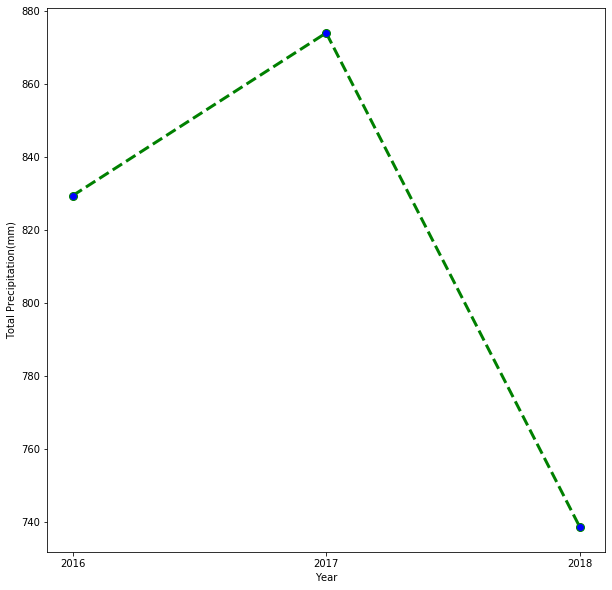

[829.4000000000002, 874.0000000000003, 738.6]

In [189]:
import numpy as np

date_from = [pd.Timestamp(2015, 5, 9), pd.Timestamp(2016, 5, 27), pd.Timestamp(2017, 7, 1)]
date_to = [pd.Timestamp(2016, 5, 8), pd.Timestamp(2017, 5, 26), pd.Timestamp(2018, 6, 30)]

total_precipitation = []
df_yearly_precip = pd.DataFrame()
Years = [2016, 2017, 2018]


#Calculating cumulative precipitation for each time period chosen for station 5733(Xanten)
i = 0
for item in Years:
    isWithinDaterange = (df_selectedDateRange['time'] <= date_to[i]) & (df_selectedDateRange['time'] >= date_from[i])
    data_frame=df_selectedDateRange[isWithinDaterange]
    # Change column name for required station id in the next line
    total_precipitation.append(data_frame[data_frame['time']==date_to[i]][selected_station].values[0])    
    i += 1
 

totalPrec = [total_precipitation[0], total_precipitation[1], total_precipitation[2]]
df_yearly_precip['time'] = Years
df_yearly_precip['cum_precipitation(mm)'] = totalPrec
#exporting data to csv for correlation calculation
export_csv = df_yearly_precip.to_csv (r'Precipitation_Yearly_Data.csv', index = None, header=True)


plt.figure(figsize=(10,10))
plt.plot(Years, totalPrec, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
plt.xticks(np.arange(2016, 2019,1 ))

plt.xlabel('Year')
plt.ylabel('Total Precipitation(mm)')
    
plt.show() 
totalPrec